<h1><center>¿HILLARY CLINTON O DONALD TRUMP?</center></h1> <h1>

<h2><center>Prediciendo quién es quién con tweets</center></h2>

<h2><center>Métodos Bayesianos</center></h2>

Importamos los paquetes relevantes para leer los datos y crear los wordclouds

In [1]:
import pandas as pd 
import numpy as np

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data_tweets.csv')

Creamos el corpus al aunar los tweets en un solo texto

In [3]:
corpus = []
for i in range(len(df['text'])):
    tweet = df['text'][i]
    corpus.append(tweet)
    
corpus = str(corpus)

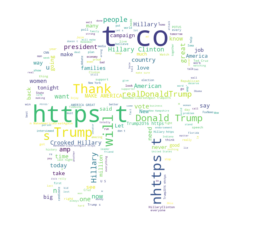

In [4]:
## Seleccionamos las stop-words

stopwords = set(STOPWORDS)

## Seleccionamos una 'máscara' para dar forma a la nube de palabras

wave_mask = np.array(Image.open("gop2.jpg"))
wordcloud = WordCloud(stopwords = stopwords, background_color = "white", mask = wave_mask).generate(corpus)

## Mostramos el resultado final

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('Trump_wordcloud.png')

Identificamos a Clinton y Trump para la última nube

In [5]:
hillary = df['text'][df['handle'] == 'HillaryClinton']
trump = df[['text']][df['handle'] == 'realDonaldTrump']

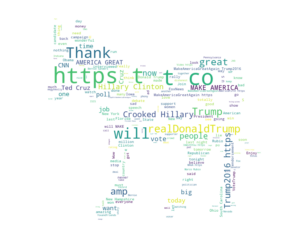

In [6]:
## Desagregamos por autor

tweets_by_author = df.groupby(['handle'])['text'].apply(list)

text = ' '.join(tweets_by_author[1])

## Seleccionamos stop-words

stopwords = set(STOPWORDS)

## Nueva 'máscara' del Partido Demócrata para Hillary Clinton

wave_mask = np.array(Image.open("dem.jpg"))
wordcloud = WordCloud(stopwords = stopwords, background_color = "white", mask = wave_mask).generate(text)

## Resultado final

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

A continuación procedemos a realizar Data Engineering para obtener los valores TF-IDF

In [7]:
import turicreate as tc

tweets = tc.SFrame('python.csv')

Finished parsing file /home/jose/Desktop/Universidad/5º Curso/Primer cuatrimestre/Métodos Bayesianos/Primer Proyecto/python.csv

Parsing completed. Parsed 100 lines in 0.020345 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file /home/jose/Desktop/Universidad/5º Curso/Primer cuatrimestre/Métodos Bayesianos/Primer Proyecto/python.csv

Parsing completed. Parsed 6444 lines in 0.020823 secs.

In [8]:
tweets

handle,clean_text
HillaryClinton,question election can putplans action will make ...
HillaryClinton,last night donald trumpsaid paying taxes smart ...
HillaryClinton,couldnt proudhillaryclinton vision ...
HillaryClinton,stand together theresnothing cant make sure ...
HillaryClinton,candidates asked theydconfront racial injus ...
realDonaldTrump,join pm rally tomorrowmidamerica center cou ...
HillaryClinton,election important sit gomake sure youre ...
HillaryClinton,donald trump goeslowregister vote ...
realDonaldTrump,will government peoplejoin movement today ...
HillaryClinton,trump offered singleproposal reduce friction ...


Creamos los valores de TF-IDF y clasificamos por autor

In [9]:
tweets['tf_idf'] = tc.text_analytics.tf_idf(tweets['clean_text'])
tweets['class'] = tweets['handle'].apply(lambda x:1 if x == 'HillaryClinton' else 0)

In [10]:
tweets

handle,clean_text,tf_idf,class
HillaryClinton,question election can putplans action will make ...,"{'better':4.328253487806548, ...",1
HillaryClinton,last night donald trumpsaid paying taxes smart ...,"{'unpatriotic':8.770904744296866, ...",1
HillaryClinton,couldnt proudhillaryclinton vision ...,"{'potus':3.6957309290630382, ...",1
HillaryClinton,stand together theresnothing cant make sure ...,"{'vote':3.5134093722690833, ...",1
HillaryClinton,candidates asked theydconfront racial injus ...,"{'answer':5.937691400240649, ...",1
realDonaldTrump,join pm rally tomorrowmidamerica center cou ...,"{'council':7.384610383176974, ...",0
HillaryClinton,election important sit gomake sure youre ...,{'nationalvoterregistrationday': ...,1
HillaryClinton,donald trump goeslowregister vote ...,"{'lowregister':8.770904744296866, ...",1
realDonaldTrump,will government peoplejoin movement today ...,"{'today':3.5668980572200697, ...",0
HillaryClinton,trump offered singleproposal reduce friction ...,"{'hillaryclinton':4.175784894162275, ...",1


Dividimos los datos en entrenamiento y testeo

In [11]:
(train_data, test_data) = tweets.random_split(0.75, seed = 42)

Creamos nuestro clasificador logístico regularizado mediante Elastic Net

In [12]:
ml_model = tc.logistic_classifier.create(train_data, target = 'class', features = ['tf_idf'],
                                         l1_penalty = 10, l2_penalty = 1000,
                                         validation_set = None)

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 1.019338     | 0.498237          |

| 1         | 2        | 0.000134  | 1.341905     | 0.977598          |

| 2         | 3        | 0.000134  | 1.377959     | 0.983613          |

| 3         | 4        | 0.000134  | 1.413407     | 0.986517          |

| 4         | 5        | 0.000134  | 1.451432     | 0.987762          |

| 5         | 6        | 0.000134  | 1.488581     | 0.988799          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Evaluamos el rendimiento en el testing set

In [13]:
ml_model.evaluate(test_data)

{'accuracy': 0.929143561306223,
 'auc': 0.979735743708763,
 'confusion_matrix': Columns:
 	target_label	int
 	predicted_label	int
 	count	int
 
 Rows: 4
 
 Data:
 +--------------+-----------------+-------+
 | target_label | predicted_label | count |
 +--------------+-----------------+-------+
 |      0       |        1        |   63  |
 |      1       |        0        |   52  |
 |      0       |        0        |  736  |
 |      1       |        1        |  772  |
 +--------------+-----------------+-------+
 [4 rows x 3 columns],
 'f1_score': 0.9306811332127788,
 'log_loss': 0.3760927354011142,
 'precision': 0.9245508982035928,
 'recall': 0.9368932038834952,
 'roc_curve': Columns:
 	threshold	float
 	fpr	float
 	tpr	float
 	p	int
 	n	int
 
 Rows: 1001
 
 Data:
 +-----------+-----+-----+-----+-----+
 | threshold | fpr | tpr |  p  |  n  |
 +-----------+-----+-----+-----+-----+
 |    0.0    | 1.0 | 1.0 | 824 | 799 |
 |   0.001   | 1.0 | 1.0 | 824 | 799 |
 |   0.002   | 1.0 | 1.0 | 824 | 

Proponemos un loop para el hyperparameter tunning de L1 y L2

In [ ]:
import numpy as np

values = np.logspace(1, 7, num = 5)
targets = test_data['class']
f1_scores = []
for l1_punish in values:
    for l2_punish in values:
        ml_model = tc.logistic_classifier.create(train_data, target = 'class', features = ['tf_idf'],
                                         l1_penalty = l1_punish, l2_penalty = l2_punish,
                                         validation_set = None)
        predictions = ml_model.predict(test_data)
        score = tc.evaluation.f1_score(targets, predictions)
        f1_scores.append(score)

print(max(f1_scores))

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.016703     | 0.498237          |

| 1         | 2        | 0.000134  | 0.306638     | 0.977598          |

| 2         | 3        | 0.000134  | 0.342444     | 0.984028          |

| 3         | 4        | 0.000134  | 0.378578     | 0.987762          |

| 4         | 5        | 0.000134  | 0.414376     | 0.989421          |

| 5         | 6        | 0.000134  | 0.451556     | 0.990873          |

| 10        | 11       | 0.000134  | 0.631897     | 0.994192          |

+-----------+----------+-----------+--------------+-------------------+

Completed (Iteration limit reached).

This model may not be optimal. To improve it, consider increasing `max_iterations`.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013925     | 0.498237          |

| 1         | 2        | 0.000134  | 0.318639     | 0.977598          |

| 2         | 3        | 0.000134  | 0.357496     | 0.984028          |

| 3         | 4        | 0.000134  | 0.395618     | 0.987762          |

| 4         | 5        | 0.000134  | 0.434167     | 0.989006          |

| 5         | 6        | 0.000134  | 0.475049     | 0.989836          |

| 8         | 9        | 0.000134  | 0.593496     | 0.991703          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014219     | 0.498237          |

| 1         | 2        | 0.000134  | 0.330699     | 0.977598          |

| 2         | 3        | 0.000134  | 0.367803     | 0.981539          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.012892     | 0.498237          |

| 1         | 2        | 0.000134  | 0.337577     | 0.973657          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014949     | 0.498237          |

| 1         | 2        | 0.000677  | 0.289341     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.027142     | 0.498237          |

| 1         | 2        | 0.000677  | 0.286454     | 0.663348          |

| 2         | 3        | 0.000451  | 0.335080     | 0.754615          |

| 3         | 4        | 0.000451  | 0.371452     | 0.753993          |

| 4         | 5        | 0.000451  | 0.408166     | 0.754200          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014343     | 0.498237          |

| 1         | 2        | 0.000677  | 0.278516     | 0.663348          |

| 2         | 3        | 0.000451  | 0.332425     | 0.754823          |

| 3         | 4        | 0.000451  | 0.371000     | 0.754823          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014189     | 0.498237          |

| 1         | 2        | 0.000451  | 0.272427     | 0.646546          |

| 2         | 3        | 0.000451  | 0.307941     | 0.646961          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013505     | 0.498237          |

| 1         | 2        | 0.000677  | 0.263847     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.020334     | 0.498237          |

| 1         | 2        | 0.000677  | 0.284325     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014572     | 0.498237          |

| 1         | 2        | 0.000677  | 0.273222     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014373     | 0.498237          |

| 1         | 2        | 0.000677  | 0.270899     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013914     | 0.498237          |

| 1         | 2        | 0.000677  | 0.268695     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.014492     | 0.498237          |

| 1         | 2        | 0.000677  | 0.275927     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013863     | 0.498237          |

| 1         | 2        | 0.000677  | 0.260755     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.016052     | 0.498237          |

| 1         | 2        | 0.000677  | 0.272178     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013785     | 0.498237          |

| 1         | 2        | 0.000677  | 0.260272     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.

Logistic regression:

--------------------------------------------------------

Number of examples          : 4821

Number of classes           : 2

Number of feature columns   : 1

Number of unpacked features : 8595

Number of coefficients      : 8596

Starting Accelerated Gradient (FISTA)

--------------------------------------------------------

Tuning step size. First iteration could take longer than subsequent iterations.

+-----------+----------+-----------+--------------+-------------------+

| Iteration | Passes   | Step size | Elapsed Time | Training Accuracy |

+-----------+----------+-----------+--------------+-------------------+

| 0         | 1        | 1.000000  | 0.013527     | 0.498237          |

| 1         | 2        | 0.000677  | 0.269603     | 0.501763          |

+-----------+----------+-----------+--------------+-------------------+

SUCCESS: Optimal solution found.